In [11]:
from qbuki import *

# qbuki.gpt

`qbuki.gpt` provides tools for working the Generalized Probablistic Theories, of which quantum theory is just one example.

For example, we can create a GPT from a probability table, in this case a $5 \times 5$ probability table of rank-3. By convention, we take the first row to be all 1's: e.g., the first row corresponds to the unit effect $u$, which gives probability 1 for any state.

In [12]:
P = rand_probs_table(5,5,3)
P

array([[1.   , 1.   , 1.   , 1.   , 1.   ],
       [0.323, 0.139, 0.451, 0.431, 0.497],
       [0.368, 0.155, 0.522, 0.494, 0.577],
       [0.553, 0.484, 0.189, 0.582, 0.087],
       [0.489, 0.354, 0.343, 0.562, 0.306]])

In [13]:
gpt = GPT.from_probability_table(P)

We could have also provided directly the effect and state vectors: `GPT(effects, states, unit_effect=None, maximally_mixed_state=None)`. By default, the unit effect is $(1,0,0,\dots)$ and the maximally mixed state is the average of all the states.

Using a specialized full rank decomposition of the probability table (`gpt_full_rank_decomposition(M)`), we can obtain states and effects.

For example, the states (columns). Notice that the dimensionality is 3, and because of our convention above, the first component is always 1: thus $u \cdot s = 1$ for any state.

In [14]:
gpt.states

array([[ 1.   ,  1.   ,  1.   ,  1.   ,  1.   ],
       [ 0.253,  0.384, -0.314,  0.161, -0.485],
       [-0.121,  0.396,  0.054, -0.408,  0.08 ]])

Meanwhile, we have the effect vectors (rows), the first being the unit effect. Note that the first $5$ are the effects needed to recover $P$, while the latter half of the effects are given by $u - e$. 

In [25]:
gpt.effects

array([[ 1.   ,  0.   ,  0.   ],
       [ 0.368, -0.31 , -0.278],
       [ 0.423, -0.369, -0.319],
       [ 0.379,  0.558, -0.276],
       [ 0.411,  0.166, -0.304],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.632,  0.31 ,  0.278],
       [ 0.577,  0.369,  0.319],
       [ 0.621, -0.558,  0.276],
       [ 0.589, -0.166,  0.304]])

So:

In [26]:
S = gpt.states
E = gpt.effects[:int(len(gpt.effects)/2)]

np.allclose(E @ S, P)

True

We can visualize the convex hull of the state vectors. Since the first component of all the states is 1, we can visualize the 3D state space in 2D:

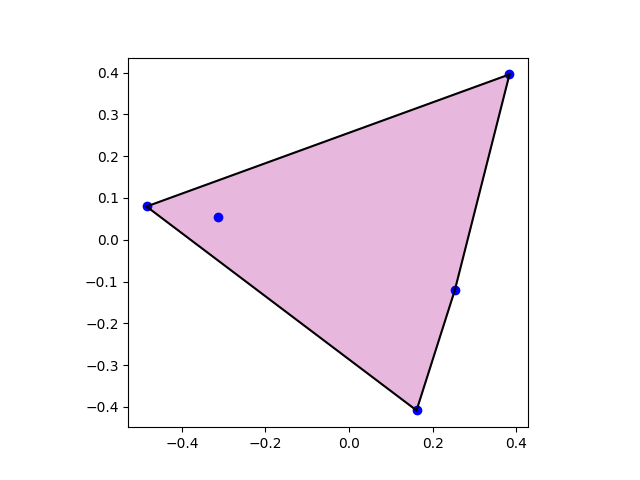

In [27]:
%matplotlib ipympl
ax = plot_convex_hull(gpt.state_space)

And of the effect vectors:

<Axes3DSubplot:>

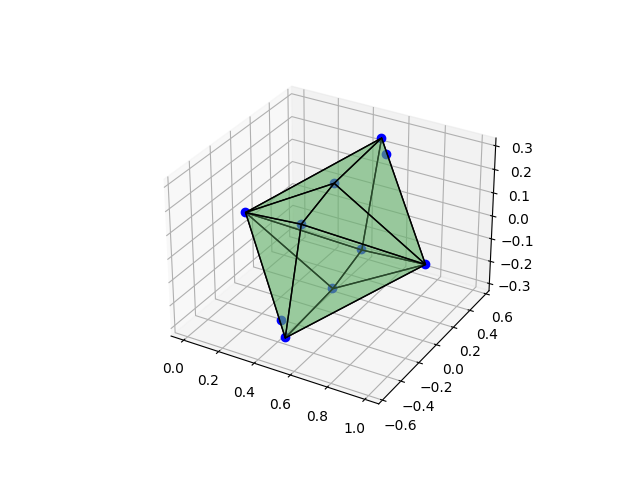

In [28]:
%matplotlib ipympl
plot_convex_hull(gpt.effect_space)

We can also consider the space of logical states, which are all the states which give valid probabilities on each of the effects, and visualize it together with the empirical state space. We can see that the former is always larger than the latter: the true state space can be taken to lie between them.

<AxesSubplot:>

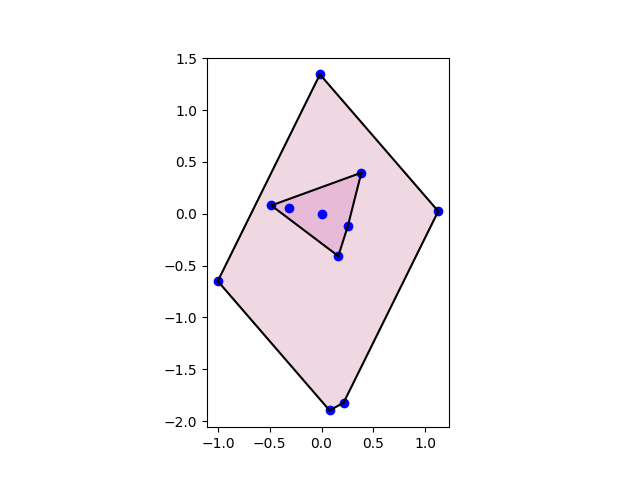

In [29]:
%matplotlib ipympl
ax = plot_convex_hull(gpt.state_space)
plot_convex_hull(gpt.logical_state_space, ax=ax)

And similarly, the logical effect space, which are all the effects which give valid probabilities on each of the states:

<Axes3DSubplot:>

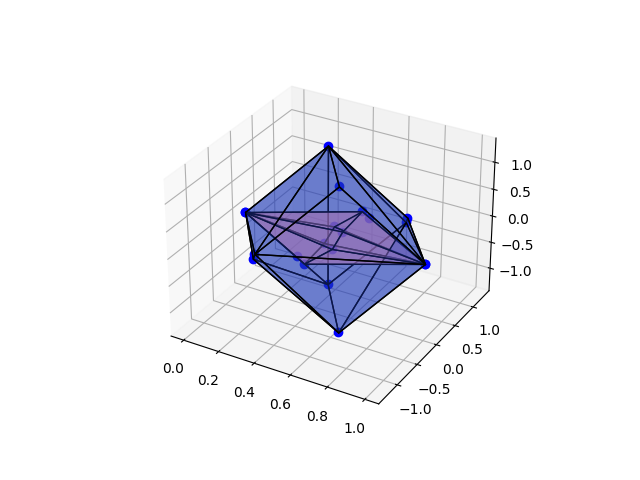

In [31]:
%matplotlib ipympl
ax = plot_convex_hull(gpt.effect_space)
plot_convex_hull(gpt.logical_effect_space, ax=ax)

In [24]:
E = GPTEffects(gpt.sample_measurement(4))

In [25]:
rho = gpt.sample_states(1)
rho

array([[1.   ],
       [0.006],
       [0.644]])

In [26]:
p = E << rho; p

array([[0.26 ],
       [0.248],
       [0.247],
       [0.245]])

In [27]:
E << p

array([[1.   ],
       [0.006],
       [0.644]])

In [75]:
S = GPTStates(gpt.sample_states(4))

In [76]:
F = GPTEffects(gpt.sample_measurement(4))

In [77]:
(F|S) @ (~E|S) @ (E << rho)

array([[0.185],
       [0.312],
       [0.292],
       [0.211]])

In [78]:
F << rho

array([[0.185],
       [0.312],
       [0.292],
       [0.211]])

In [84]:
sigma = gpt.sample_states(1)
E << sigma

array([[0.26 ],
       [0.247],
       [0.247],
       [0.246]])

In [85]:
(E<<sigma).T @ (~E|S) @ (E << rho)

array([[0.198]])

In [86]:
(F|S) @ (~E|S)

array([[-15.834,  39.906,  24.188, -47.24 ],
       [ 22.836, -49.464, -26.864,  54.217],
       [-19.488,  44.329,  24.51 , -47.731],
       [ 13.485, -33.771, -20.834,  41.754]])

In [80]:
np.linalg.eigvals(E|S)

array([ 1.   ,  0.002, -0.001, -0.   ])

In [47]:
P_noisy = P + np.random.normal(loc=0, scale=0.001, size=P.shape)
P_noisy[P_noisy < 0] = 0
P_noisy[P_noisy > 1] = 1
F = rank_approximation(P_noisy, 3)
print(np.linalg.svd(F)[1])
print(np.all(F >= 0) and np.all(F <= 1))

[5.698 2.343 1.814 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
False
